# AI for stock market prediction: Using LLMs for TimeSeries Predictions (TimesFM Extension of the Experimental Pipeline)

This notebook extends the methodology developed in the main file **PROJECT.ipynb**, where the forecasting and trading evaluation pipeline was originally implemented for ARIMA and LLM-based models (GPT-3.5 and GPT-4).

The objective of this notebook is to reproduce **the exact same experimental flow**, maintaining identical:

- dataset  
- preprocessing steps  
- train/test split logic  
- autoregressive forecasting structure  
- Trading Protocol and Monte Carlo robustness evaluation  
- performance metrics and summary tables  

The only change is the forecasting model, which is replaced with **Google’s TimesFM** — a state-of-the-art foundation model for time series forecasting released by Google Research and available through the Hugging Face Transformers library.

By keeping the experimental setup and evaluation methodology identical to the original notebook, this extension enables a **direct and fair comparison** between:

- traditional statistical modeling (**ARIMA**)  
- LLM-based zero-shot time-series prediction (**LLMTime GPT-3.5 and GPT-4**)  
- transformer-based dedicated time-series foundation modeling (**TimesFM**)  

The final TimesFM results are integrated into the overall comparative analysis and summarized together with the other models in the conclusion section of the main notebook.

References: [Blog Post](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/TimesFM) and [Github repo](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/TimesFM)


In [26]:
!pip install -q --upgrade transformers accelerate pandas numpy matplotlib scikit-learn


In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
from transformers import TimesFmModelForPrediction

In [28]:
SEED = 42
rng = np.random.default_rng(SEED)

# --- Experiment constants (matching your PROJECT notebook) ---
LAG = 12
TRAIN_SIZE = 150          # per split
PREDICTION_SIZE = 29      # per split
FORECAST_HORIZON = PREDICTION_SIZE
INITIAL_CAPITAL = 10_000

print(f"Initial Capital: ${INITIAL_CAPITAL:,}")
print(f"Forecast Horizon: {FORECAST_HORIZON} days")


Initial Capital: $10,000
Forecast Horizon: 29 days


## 🛠️ Helper Functions
With a small adjustment of the visualization functions to show a single result, otherwise same logic (identical) as the main `PROJECT.ipynb`

In [29]:
def create_performance_summary_table(results_dict):
    """
    Create a comprehensive performance summary table for ANY set of models.

    Args:
        results_dict: dict of
            { model_key: results_dict OR {"config": ..., "results": results_dict} }
    """
    import pandas as pd

    summary_data = []

    # Optional pretty name mapping for known models
    pretty_names = {
        "arima": "ARIMA",
        "gpt3": "GPT-3.5",
        "gpt4": "GPT-4",
        "timesfm": "TimesFM",
    }

    for model_key, val in results_dict.items():
        if val is None:
            continue

        # -------------------------
        # Unwrap {"results": ...} if needed
        # -------------------------
        if isinstance(val, dict) and "results" in val and isinstance(val["results"], dict):
            res = val["results"]
        else:
            res = val

        # Skip if required fields are missing
        if "statistical_metrics" not in res or "by_strategy" not in res:
            continue

        stats = res["statistical_metrics"]
        by_strategy = res["by_strategy"]

        if not by_strategy:
            continue

        # -------------------------
        # Pretty model name
        # -------------------------
        model_name = pretty_names.get(
            model_key,
            model_key.upper().replace("_", " ")
        )

        # -------------------------
        # Find best strategy by avg_total_return
        # -------------------------
        def _get_avg_return(strategy_name):
            try:
                return by_strategy[strategy_name]["summary"]["avg_total_return"]
            except KeyError:
                return float("-inf")

        best_strategy = max(by_strategy.keys(), key=_get_avg_return)
        best_metrics = by_strategy[best_strategy]["summary"]

        # Safely pull values with defaults if missing
        rmse = stats.get("RMSE", float("nan"))
        mae = stats.get("MAE", float("nan"))
        r2 = stats.get("R2", float("nan"))
        da = stats.get("Directional_Accuracy", float("nan"))

        avg_total_return = best_metrics.get("avg_total_return", float("nan"))
        avg_final_capital = best_metrics.get("avg_final_capital", float("nan"))
        avg_profitable_pct = best_metrics.get("avg_profitable_pct", float("nan"))
        avg_num_trades = best_metrics.get("avg_num_trades", float("nan"))

        summary_data.append({
            "Model": model_name,
            "RMSE": f"{rmse:.6f}",
            "MAE": f"{mae:.6f}",
            "R²": f"{r2:.4f}",
            "Directional Accuracy": f"{da:.2%}" if da == da else "n/a",
            "Total Return": f"{avg_total_return:.2%}" if avg_total_return == avg_total_return else "n/a",
            "Final Capital": f"${avg_final_capital:.2f}" if avg_final_capital == avg_final_capital else "n/a",
            "Profitable Trades": f"{avg_profitable_pct:.2%}" if avg_profitable_pct == avg_profitable_pct else "n/a",
            "Total Trades": f"{avg_num_trades:.1f}" if avg_num_trades == avg_num_trades else "n/a",
            "Best Strategy": best_strategy,
        })

    if summary_data:
        df = pd.DataFrame(summary_data)
        print("\n" + "=" * 80)
        print("COMPREHENSIVE PERFORMANCE SUMMARY TABLE")
        print("=" * 80)
        print(df.to_string(index=False))
        print("=" * 80)
        return df
    else:
        print("No valid model data available for summary table")
        return None


def plot_predictions_vs_actual(
    results_dict,
    forecast_horizon=None,
    idx=0,
    figsize=(14, 8),
):
    """
    Plot actual vs predicted returns for all models in results_dict.

    Args:
        results_dict: dict of { model_key : results OR { "config": ..., "results": ... } }
        forecast_horizon: optional int, max steps to plot (e.g. FORECAST_HORIZON)
        idx: which split index to plot
        figsize: matplotlib figure size
    """
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm

    plt.figure(figsize=figsize)

    # -------------------------
    # 1. Normalize entries (unwrap {"results": ...} if needed)
    # -------------------------
    normalized = {}
    for key, val in results_dict.items():
        if val is None:
            continue
        if isinstance(val, dict) and "results" in val and isinstance(val["results"], dict):
            normalized[key] = val["results"]
        else:
            normalized[key] = val

    if not normalized:
        print("No valid results found in results_dict.")
        return

    model_keys = list(normalized.keys())
    colors = cm.get_cmap("tab10", len(model_keys))

    # -------------------------
    # 2. Get actual series (from first model that has it)
    # -------------------------
    actual = None
    for key in model_keys:
        res = normalized[key]
        if "actual" in res and len(res["actual"]) > idx:
            actual = res["actual"][idx]
            break

    if actual is None:
        print(f"No 'actual' data found for idx={idx}.")
        return

    actual = list(actual)
    max_len = len(actual)

    # Clip by forecast_horizon if provided
    if forecast_horizon is not None:
        max_len = min(max_len, forecast_horizon)

    time_axis = range(1, max_len + 1)

    # -------------------------
    # 3. Plot actual returns
    # -------------------------
    plt.plot(
        time_axis,
        actual[:max_len],
        label="Actual Returns",
        linewidth=2.5,
        color="black",
        alpha=0.8,
    )

    # -------------------------
    # 4. Plot predictions for each model
    # -------------------------
    for i, key in enumerate(model_keys):
        res = normalized[key]
        if "predictions" not in res or "actual" not in res:
            continue
        if len(res["predictions"]) <= idx:
            continue

        preds = list(res["predictions"][idx])

        # clip preds to same length
        plot_len = min(len(preds), max_len)
        if plot_len == 0:
            continue

        model_label = key.upper().replace("_", " ")

        plt.plot(
            range(1, plot_len + 1),
            preds[:plot_len],
            label=f"{model_label} Prediction",
            linewidth=2,
            color=colors(i),
            alpha=0.8,
        )

    # -------------------------
    # 5. Formatting
    # -------------------------
    plt.title(
        f"Predicted vs Actual Returns (Split #{idx})",
        fontsize=14,
        fontweight="bold",
    )
    plt.xlabel("Forecast Step")
    plt.ylabel("Return")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_cumulative_returns_simulation(results_dict, initial_capital=10000, figsize=(12, 8), idx=0):
    """
    Plot cumulative returns for ANY set of models in results_dict.

    Args:
        results_dict: dict of { model_key : results or {"config": ..., "results": ...} }
        initial_capital: starting capital
        figsize: plot size
        idx: which split index to use
    """
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    plt.figure(figsize=figsize)

    # -------------------------
    # Normalize entries: unwrap {"results": ...} if needed
    # -------------------------
    normalized = {}
    for key, val in results_dict.items():
        if val is None:
            continue
        # if it's a wrapper like {"config": ..., "results": ...}
        if isinstance(val, dict) and "results" in val and isinstance(val["results"], dict):
            normalized[key] = val["results"]
        else:
            normalized[key] = val

    if not normalized:
        print("No valid results found in results_dict.")
        return

    model_keys = list(normalized.keys())
    colors = cm.get_cmap("tab10", len(model_keys))

    # -------------------------
    # Determine time horizon from any available model
    # -------------------------
    max_periods = 0
    for key in model_keys:
        res = normalized[key]
        if "actual" in res and len(res["actual"]) > idx:
            max_periods = max(max_periods, len(res["actual"][idx]))

    if max_periods == 0:
        print("Could not determine max_periods (no 'actual' data for given idx).")
        return

    # -------------------------
    # BUY & HOLD baseline
    # -------------------------
    actual_returns = None
    for key in model_keys:
        res = normalized[key]
        if "actual" in res and len(res["actual"]) > idx:
            actual_returns = res["actual"][idx]
            break

    if actual_returns is not None:
        buy_hold = [initial_capital]
        capital = initial_capital
        for ret in actual_returns:
            capital *= (1 + ret)
            buy_hold.append(capital)

        plt.plot(
            range(len(buy_hold)),
            buy_hold,
            '--',
            color="gray",
            linewidth=2,
            alpha=0.8,
            label="Buy & Hold",
        )

    # -------------------------
    # Plot each model's trading performance
    # -------------------------
    for i, key in enumerate(model_keys):
        res = normalized[key]

        if "predictions" not in res or "actual" not in res:
            continue
        if len(res["predictions"]) <= idx or len(res["actual"]) <= idx:
            continue

        preds = res["predictions"][idx]
        actual = res["actual"][idx]

        cumulative = [initial_capital]
        capital = initial_capital

        # simple rule: invest if predicted return > 0
        for p, a in zip(preds, actual):
            if p > 0:
                capital *= (1 + a)
            cumulative.append(capital)

        model_label = key.upper().replace("_", " ")
        plt.plot(
            range(len(cumulative)),
            cumulative,
            label=f"{model_label} Trading",
            linewidth=2,
            color=colors(i),
        )

    # -------------------------
    # Formatting
    # -------------------------
    plt.title("Cumulative Trading Performance Comparison", fontsize=14, fontweight="bold")
    plt.xlabel("Trading Period")
    plt.ylabel("Portfolio Value ($)")
    plt.grid(True, alpha=0.3)
    plt.axhline(y=initial_capital, color="black", linestyle=":", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [30]:
def split_time_series(series: pd.Series, train_size: int, pred_size: int):
    """
    Create multiple train/test splits from a univariate time series.

    We use a walk-forward style:
    - Each split has `train_size` points for training
    - Followed by `pred_size` points used as the forecast horizon
    - Window advances by `pred_size` each time (non-overlapping test windows)

    Returns: list of (train_series, test_series), preserving index & dtype.
    """
    series = series.dropna()
    n = len(series)
    splits = []

    start = 0
    while start + train_size + pred_size <= n:
        train_end = start + train_size
        test_end = train_end + pred_size

        train = series.iloc[start:train_end]
        test = series.iloc[train_end:test_end]

        splits.append((train, test))
        start += pred_size  # move by one forecast window

    return splits

def _flatten_list_of_arrays(x):
    """Flatten list-of-1D arrays into a single 1D numpy array."""
    if isinstance(x, (list, tuple)):
        parts = []
        for s in x:
            arr = np.asarray(s).ravel()
            parts.append(arr)
        return np.concatenate(parts)
    return np.asarray(x).ravel()

def calculate_metrics(true_vals, preds):
    """
    true_vals, preds: list of 1D arrays (one per split), or single arrays.

    Returns dict with keys used in your PROJECT notebook:
    - RMSE
    - MAE
    - R2
    """
    y_true = _flatten_list_of_arrays(true_vals)
    y_pred = _flatten_list_of_arrays(preds)

    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))

    return {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "MSE": float(mse),
    }


## Model Setup and Implementation

### 🧲 TimesFM (Time-Series Foundation Model)

- Transformer model designed specifically for time-series forecasting  
- Expected to capture general temporal patterns from large-scale pretraining  
- No need for dataset-specific training; works in zero-shot mode  
- More structured than LLMs but still not tuned for financial return prediction  
- Produces stable forecasts but struggles with noisy, unpredictable market data  


In [31]:
def returns_trading_performance_with_strategy(
    predicted_returns,
    actual_returns,
    initial_capital=1000,
    strategy="threshold",
    threshold=0.001,
    verbose=True,
):
    """
    Trading performance evaluation with multiple strategies.

    Supports:
      - A single series: 1D array/list
      - Multiple series: list of 1D arrays/lists

    Strategies:
        'threshold': go long if predicted_return > threshold
        'relative': go long if predicted_return > 0
        'top_quartile': go long only on the top 25% predicted returns (per series)

    Returns:
        final_capital_agg,
        total_return_pct_agg,
        accuracy_agg,
        profitable_trades_pct_agg,
        trade_info (dict with per-series details & summary)
    """

    def _to_list_of_arrays(x):
        if isinstance(x, (list, tuple)):
            # list-of-series or single series as list
            if len(x) == 0:
                return []
            if isinstance(x[0], (list, np.ndarray, pd.Series)):
                return [np.asarray(s, dtype=float).ravel() for s in x]
        # otherwise single series
        return [np.asarray(x, dtype=float).ravel()]

    preds_list = _to_list_of_arrays(predicted_returns)
    actual_list = _to_list_of_arrays(actual_returns)

    assert len(preds_list) == len(actual_list), "predicted vs actual length mismatch"

    per_series_results = []

    for series_idx, (pred, act) in enumerate(zip(preds_list, actual_list)):
        assert len(pred) == len(act), "Per-series pred/actual length mismatch"

        # --- Decide buy signals ---
        if strategy == "threshold":
            buy_signals = pred > threshold
        elif strategy == "relative":
            buy_signals = pred > 0.0
        elif strategy == "top_quartile":
            if len(pred) == 0:
                buy_signals = np.zeros_like(pred, dtype=bool)
            else:
                q = np.quantile(pred, 0.75)
                buy_signals = pred >= q
        else:
            raise ValueError("Strategy must be 'threshold', 'relative', or 'top_quartile'")

        capital = float(initial_capital)
        trades = []

        for do_buy, actual_ret in zip(buy_signals, act):
            if do_buy:
                capital *= (1.0 + actual_ret)
                trades.append(actual_ret)
            else:
                trades.append(0.0)

        final_capital = float(capital)
        total_return_pct = (final_capital - initial_capital) / initial_capital

        trades_arr = np.asarray(trades, dtype=float)
        traded_mask = trades_arr != 0.0

        # Directional accuracy: sign(pred) vs sign(actual)
        direction_correct = np.sign(pred) == np.sign(act)
        accuracy = float(direction_correct.mean()) if len(direction_correct) > 0 else np.nan

        num_trades = int(traded_mask.sum())
        if num_trades > 0:
            profitable_trades_pct = float((trades_arr[traded_mask] > 0).mean())
            avg_trade_return = float(trades_arr[traded_mask].mean())
        else:
            profitable_trades_pct = 0.0
            avg_trade_return = 0.0

        per_series_results.append({
            "series_idx": series_idx,
            "final_capital": final_capital,
            "total_return_pct": total_return_pct,
            "accuracy": accuracy,
            "num_trades": num_trades,
            "profitable_trades_pct": profitable_trades_pct,
            "avg_trade_return": avg_trade_return,
        })

    # Aggregate across series
    final_capitals = np.array([r["final_capital"] for r in per_series_results], dtype=float)
    total_returns = np.array([r["total_return_pct"] for r in per_series_results], dtype=float)
    accuracies = np.array([r["accuracy"] for r in per_series_results], dtype=float)
    profitable_pcts = np.array([r["profitable_trades_pct"] for r in per_series_results], dtype=float)
    num_trades_arr = np.array([r["num_trades"] for r in per_series_results], dtype=float)
    avg_trade_returns = np.array([r["avg_trade_return"] for r in per_series_results], dtype=float)

    final_capital_agg = float(final_capitals.mean())
    total_return_pct_agg = float(total_returns.mean())
    accuracy_agg = float(accuracies.mean())
    profitable_trades_pct_agg = float(profitable_pcts.mean())
    avg_num_trades = float(num_trades_arr.mean())
    avg_trade_return = float(avg_trade_returns.mean())

    trade_info = {
        "avg_final_capital": final_capital_agg,
        "avg_total_return_pct": total_return_pct_agg,
        "avg_accuracy": accuracy_agg,
        "avg_profitable_trades_pct": profitable_trades_pct_agg,
        "num_trades": avg_num_trades,          # averaged for compatibility
        "avg_trade_return": avg_trade_return,
        "strategy_used": strategy,
        "threshold_used": threshold if strategy == "threshold" else None,
        "per_series": per_series_results,
    }

    if verbose:
        print(f"=== Returns Trading Performance ({strategy}) ===")
        print(f"Initial Capital per series: ${initial_capital:.2f}")
        print(f"Avg Final Capital: ${final_capital_agg:.2f}")
        print(f"Avg Total Return: {total_return_pct_agg:.2%}")
        print(f"Avg Directional Accuracy: {accuracy_agg:.2%}")
        print(f"Avg Profitable Trades: {profitable_trades_pct_agg:.2%}")
        print(f"Avg Number of Trades: {avg_num_trades:.2f}")
        print(f"Avg Trade Return: {avg_trade_return:.4f}")

    return (
        final_capital_agg,
        total_return_pct_agg,
        accuracy_agg,
        profitable_trades_pct_agg,
        trade_info,
    )

def timesfm_forecast(
    data_history,
    data_true_forecast,
    forecast_horizon: int,
    model: TimesFmModelForPrediction,
    freq_id: int = 0,  # 0 = high-frequency (up to daily)
):
    """
    data_history: list of 1D arrays (train series per split)
    data_true_forecast: list of 1D arrays (test series per split) -- not used except for shape consistency
    forecast_horizon: how many steps ahead to take from TimesFM output

    Returns list of 1D numpy arrays, same shape structure as data_true_forecast.
    """
    model_device = next(model.parameters()).device

    # Batch all splits together as list of 1D tensors
    past_values = [
        torch.tensor(ts, dtype=torch.float32, device=model_device)
        for ts in data_history
    ]

    freq_tensor = torch.full(
        (len(past_values),),
        fill_value=freq_id,
        dtype=torch.long,
        device=model_device,
    )

    with torch.no_grad():
        outputs = model(
            past_values=past_values,
            freq=freq_tensor,
            return_dict=True,
        )
        mean_predictions = outputs.mean_predictions.float().cpu().numpy()  # [B, horizon_len]

    horizon_len = mean_predictions.shape[1]
    if forecast_horizon > horizon_len:
        raise ValueError(
            f"Requested forecast_horizon={forecast_horizon}, "
            f"but model horizon_len={horizon_len}."
        )

    preds = []
    for i in range(len(data_history)):
        preds.append(mean_predictions[i, :forecast_horizon])

    return preds



In [32]:


def predict_returns_with_trading_timesfm(
    train_data,
    forecast_horizon: int = FORECAST_HORIZON,
    initial_capital: float = INITIAL_CAPITAL,
    strategies=("threshold", "relative", "top_quartile"),
    monte_carlo_runs: int = 1000,
    noise_std: float = 0.001,      # 0.1% prediction noise per run
    seed: int = 42,
    verbose: bool = True,
):
    """
    TimesFM version of your predict_returns_with_trading.

    Returns dict:
      - 'model': "TIMESFM"
      - 'statistical_metrics': dict(RMSE, MAE, R2, Directional_Accuracy, ...)
      - 'by_strategy': { strategy_name: { 'summary', 'runs' } }
      - 'predictions': list of arrays (noiseless base)
      - 'actual': list of arrays (true future)
    """
    if verbose:
        print(" Model selected: TIMESFM")
        print(" Using real S&P 500 returns data")
        print(f" Monte Carlo: {monte_carlo_runs} runs per strategy")
        print(f" Noise on predictions: N(0, {noise_std})")

    # -------------------------
    # 1. Unpack train/test splits
    # -------------------------
    data_history = [s[0].values for s in train_data]       # past (prompt) data
    data_true_forecast = [s[1].values for s in train_data] # future (target) data

    # -------------------------
    # 2. Base TimesFM prediction (noiseless)
    # -------------------------
    preds_base = timesfm_forecast(
        data_history=data_history,
        data_true_forecast=data_true_forecast,
        forecast_horizon=forecast_horizon,
        model=model,
    )

    # -------------------------
    # 3. Statistical metrics on noiseless predictions
    # -------------------------
    true_vals = data_true_forecast
    metrics = calculate_metrics(true_vals, preds_base)

    # Add global directional accuracy (sign correctness over ALL splits)
    true_flat = np.concatenate([np.asarray(s) for s in true_vals])
    pred_flat = np.concatenate([np.asarray(p) for p in preds_base])

    direction_correct = np.sign(true_flat) == np.sign(pred_flat)
    directional_accuracy = float(direction_correct.mean())

    metrics["Directional_Accuracy"] = directional_accuracy

    print("\n===== TIMESFM Statistical Metrics (noiseless) =====")
    print(f"RMSE: {metrics['RMSE']:.6f}")
    print(f"MAE: {metrics['MAE']:.6f}")
    print(f"R²:  {metrics['R2']:.4f}")
    print(f"Directional Accuracy: {metrics['Directional_Accuracy']:.2%}")

    # -------------------------
    # 4. Monte Carlo trading simulations by strategy
    # -------------------------
    rng = np.random.default_rng(seed)
    by_strategy = {}

    for strategy in strategies:
        print(f"\n===== Strategy: {strategy} — {monte_carlo_runs} runs =====")

        run_records = []
        for _ in range(monte_carlo_runs):
            # Add Gaussian noise to base predictions to simulate forecast uncertainty
            noisy_preds = [
                np.array(p) + rng.normal(0.0, noise_std, size=len(p))
                for p in preds_base
            ]

            final_capital, total_return, accuracy, profitable_pct, trade_info = (
                returns_trading_performance_with_strategy(
                    predicted_returns=noisy_preds,
                    actual_returns=true_vals,
                    initial_capital=initial_capital,
                    strategy=strategy,
                    threshold=0.0005,  # 0.05% threshold like in your notebook
                    verbose=False,
                )
            )

            run_records.append({
                "final_capital": final_capital,
                "total_return": total_return,
                "directional_acc": accuracy,
                "profitable_pct": profitable_pct,
                "num_trades": trade_info.get("num_trades", np.nan),
                "avg_trade_return": trade_info.get("avg_trade_return", np.nan),
            })

        df_runs = pd.DataFrame(run_records)

        summary = {
            "avg_final_capital": float(df_runs["final_capital"].mean()),
            "std_final_capital": float(df_runs["final_capital"].std(ddof=1)),
            "avg_total_return": float(df_runs["total_return"].mean()),
            "std_total_return": float(df_runs["total_return"].std(ddof=1)),
            "avg_directional_acc": float(df_runs["directional_acc"].mean()),
            "avg_profitable_pct": float(df_runs["profitable_pct"].mean()),
            "avg_num_trades": float(df_runs["num_trades"].mean()),
            "avg_trade_return": float(df_runs["avg_trade_return"].mean()),
            "p05_total_return": float(df_runs["total_return"].quantile(0.05)),
            "p50_total_return": float(df_runs["total_return"].quantile(0.50)),
            "p95_total_return": float(df_runs["total_return"].quantile(0.95)),
        }

        print(
            f" Avg Total Return: {summary['avg_total_return']:.2%} "
            f"(± {summary['std_total_return']:.2%}, "
            f"p05 {summary['p05_total_return']:.2%}, "
            f"median {summary['p50_total_return']:.2%}, "
            f"p95 {summary['p95_total_return']:.2%})"
        )
        print(f" Avg Directional Accuracy: {summary['avg_directional_acc']:.2%}")
        print(f" Avg Profitable Trades:   {summary['avg_profitable_pct']:.2%}")
        print(
            f" Avg Final Capital: ${summary['avg_final_capital']:.2f} "
            f"(± ${summary['std_final_capital']:.2f})"
        )
        print(
            f" Avg #Trades: {summary['avg_num_trades']:.2f} | "
            f"Avg Trade Return: {summary['avg_trade_return']:.4%}"
        )

        by_strategy[strategy] = {
            "summary": summary,
            "runs": df_runs,
        }

    # -------------------------
    # 5. Final results dict (same shape as ARIMA / GPT models)
    # -------------------------
    results = {
        "model": "TIMESFM",
        "statistical_metrics": metrics,
        "by_strategy": by_strategy,
        "predictions": preds_base,
        "actual": true_vals,
    }

    return results


## Running the Models and Analyzing Results

In [33]:
CSV_PATH = "/content/sp500_returns_modeling.csv"  # adjust if needed

returns_data = pd.read_csv(CSV_PATH)

print("Columns:", returns_data.columns.tolist())
print("Shape:", returns_data.shape)
print(returns_data.head())

# We'll use the 'returns' column exactly like the PROJECT notebook
returns_series = returns_data["returns"].astype(float)

splits = split_time_series(returns_series, TRAIN_SIZE, PREDICTION_SIZE)

print("=" * 60)
print(f"🧩 Created {len(splits)} train-test splits for returns forecasting")
print(f"Each split - Train size: {TRAIN_SIZE}, Test size: {PREDICTION_SIZE}")
print("\nSample split structure:")
print("Train data (last 5 values):")
print(splits[0][0].tail())
print("\nTest data (first 5 values):")
print(splits[0][1].head())


Columns: ['date', 'returns', 'price', 'volume', 'rolling_volatility', 'returns_lag1', 'returns_lag2', 'returns_lag3']
Shape: (2890, 8)
                        date   returns        price        volume  \
0  2001-02-01 00:00:00-05:00  0.005461  1373.469971  1.118800e+09   
1  2001-02-02 00:00:00-05:00 -0.017474  1349.469971  1.048400e+09   
2  2001-02-03 00:00:00-05:00  0.001196  1351.083333  1.036600e+09   
3  2001-02-04 00:00:00-05:00  0.001194  1352.696696  1.024800e+09   
4  2001-02-05 00:00:00-05:00  0.001193  1354.310059  1.013000e+09   

   rolling_volatility  returns_lag1  returns_lag2  returns_lag3  
0            0.185403     -0.005620      0.007008      0.002258  
1            0.128971      0.005461     -0.005620      0.007008  
2            0.124988     -0.017474      0.005461     -0.005620  
3            0.095957      0.001196     -0.017474      0.005461  
4            0.095767      0.001194      0.001196     -0.017474  
🧩 Created 94 train-test splits for returns forecasting

For the **TimesFM model**, forecasts are also generated for all **94 splits**, using the same history–forecast structure as in the LLM setup. TimesFM produces a 29-day autoregressive prediction for each split, and the results are then aggregated to evaluate overall performance.
Since TimesFM does not require training on the specific dataset (it is a pretrained foundation model), it is applied directly in a **zero-shot manner** to every split, just like the LLM-based models.

In [34]:
model = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch",
    attn_implementation="sdpa",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
)

print("✅ Loaded TimesFM model")
print("Context length:", model.config.context_length)
print("Horizon length:", model.config.horizon_length)
print("Patch length:", model.config.patch_length)
print("Quantiles:", model.config.quantiles)


✅ Loaded TimesFM model
Context length: 2048
Horizon length: 128
Patch length: 32
Quantiles: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


In [35]:
# Single canonical TimesFM run with fixed experimental settings
timesfm_results = predict_returns_with_trading_timesfm(
    train_data=splits,
    forecast_horizon=FORECAST_HORIZON,
    initial_capital=INITIAL_CAPITAL,
    strategies=("threshold", "relative", "top_quartile"),
    monte_carlo_runs=1000,   # fixed by your experiment design
    noise_std=0.001,         # fixed by your experiment design
    seed=SEED,
    verbose=True,
)


 Model selected: TIMESFM
 Using real S&P 500 returns data
 Monte Carlo: 1000 runs per strategy
 Noise on predictions: N(0, 0.001)

===== TIMESFM Statistical Metrics (noiseless) =====
RMSE: 0.010226
MAE: 0.006100
R²:  -0.0248
Directional Accuracy: 51.91%

===== Strategy: threshold — 1000 runs =====
 Avg Total Return: -0.09% (± 0.16%, p05 -0.37%, median -0.09%, p95 0.17%)
 Avg Directional Accuracy: 50.92%
 Avg Profitable Trades:   46.23%
 Avg Final Capital: $9990.99 (± $16.27)
 Avg #Trades: 8.87 | Avg Trade Return: -0.0336%

===== Strategy: relative — 1000 runs =====
 Avg Total Return: -0.12% (± 0.19%, p05 -0.42%, median -0.11%, p95 0.19%)
 Avg Directional Accuracy: 50.94%
 Avg Profitable Trades:   48.48%
 Avg Final Capital: $9988.38 (± $18.57)
 Avg #Trades: 12.91 | Avg Trade Return: -0.0358%

===== Strategy: top_quartile — 1000 runs =====
 Avg Total Return: -0.25% (± 0.23%, p05 -0.63%, median -0.25%, p95 0.13%)
 Avg Directional Accuracy: 50.93%
 Avg Profitable Trades:   50.98%
 Avg Fina

### Results

In [36]:
comparison_results = {
    'timesfm': timesfm_results ,
}

In [37]:
summary_df = create_performance_summary_table(comparison_results)


COMPREHENSIVE PERFORMANCE SUMMARY TABLE
  Model     RMSE      MAE      R² Directional Accuracy Total Return Final Capital Profitable Trades Total Trades Best Strategy
TimesFM 0.010226 0.006100 -0.0248               51.91%       -0.09%      $9990.99            46.23%          8.9     threshold


/tmp/ipython-input-2112327146.py:137: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10", len(model_keys))


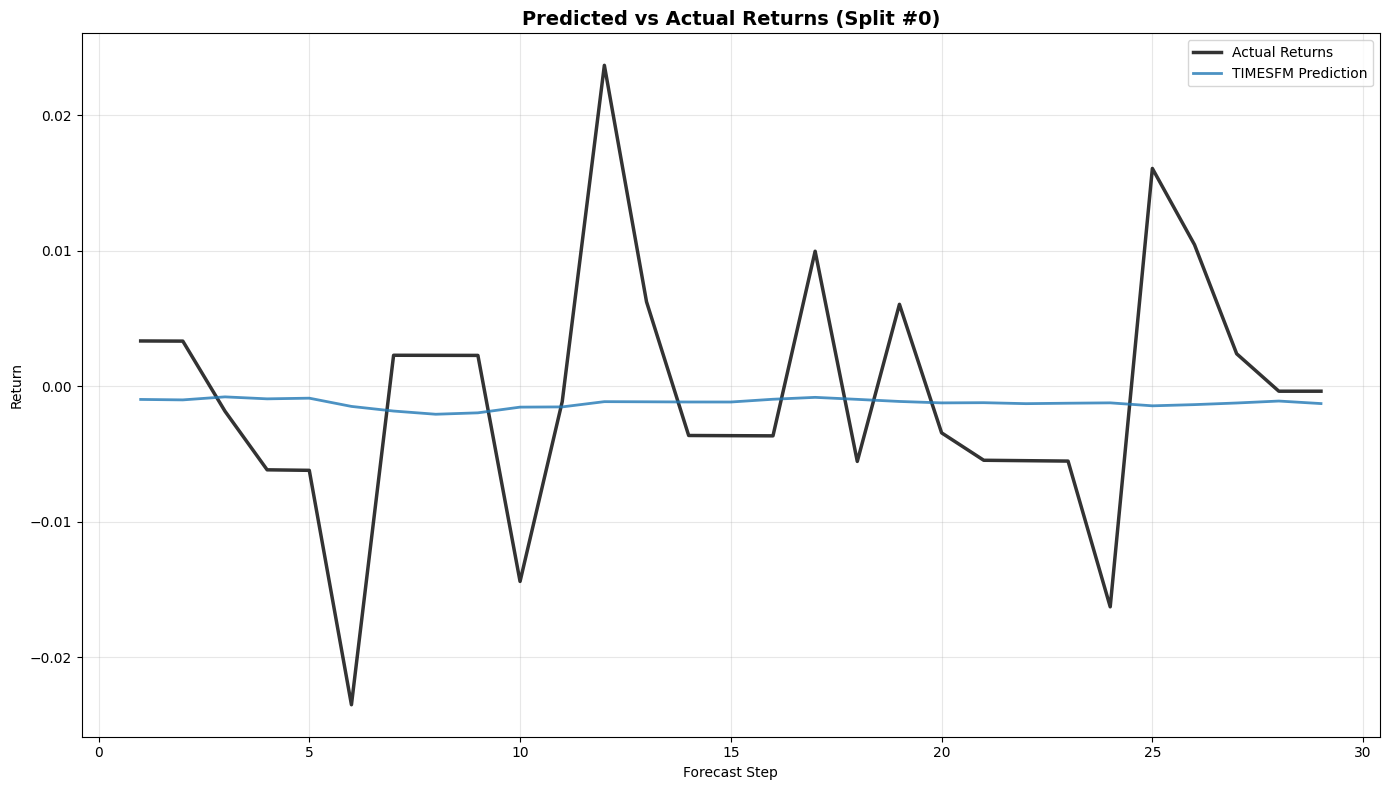

In [38]:
plot_predictions_vs_actual(comparison_results, forecast_horizon=FORECAST_HORIZON)

/tmp/ipython-input-2112327146.py:250: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10", len(model_keys))


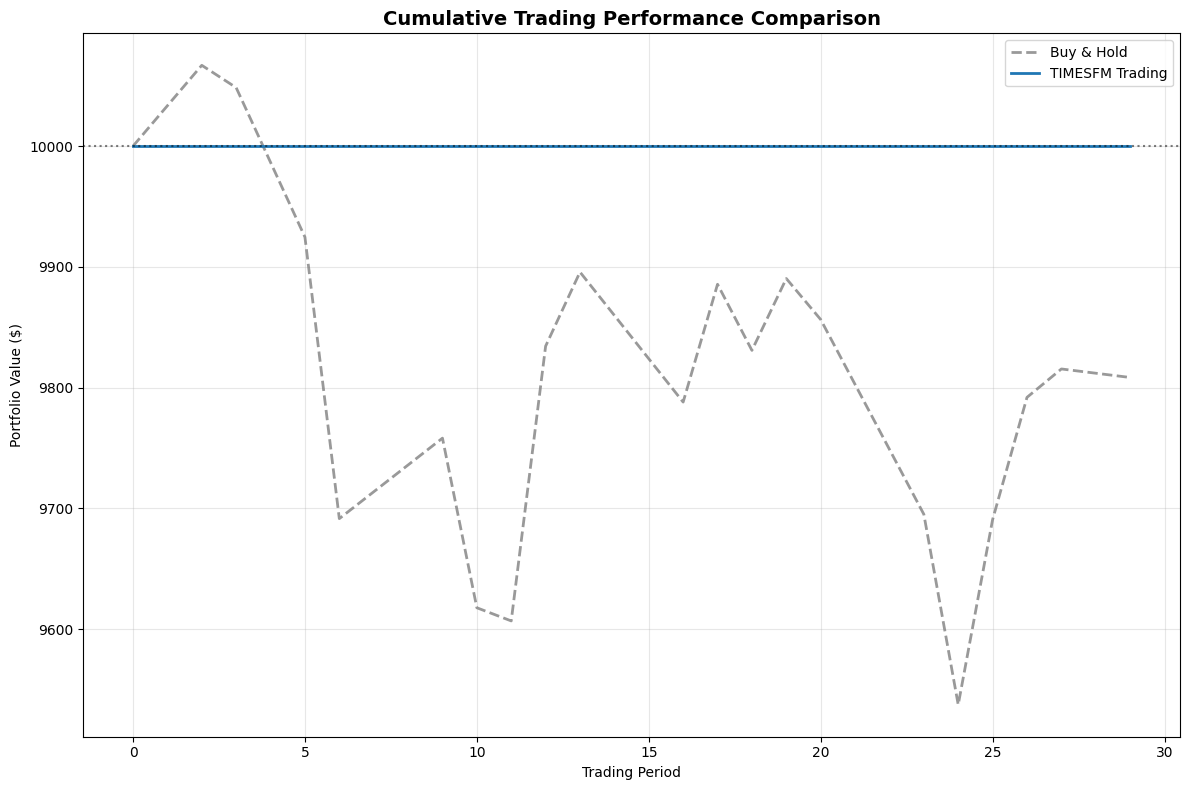

In [39]:
plot_cumulative_returns_simulation(comparison_results, initial_capital=INITIAL_CAPITAL)